## fluxo de busca de hiperparametros

1. Etapa Incial: `RandomizedSearchCV` Explorar região inicial de hiperparametros.

2. Refinamento: `RandomizedSearchCV` Explorar região promissora

3. Busca final: `BayesSearchCV`Refinamento inteligente aa região promissora

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import time

# CatBoost
from catboost import CatBoostClassifier
# sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin, clone

from scipy.stats import ttest_rel

#hiperparamentros search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import randint, uniform
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical


# Importações locais
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
from src.preprocess_utils_tic import preprocessador_titanic

## 1. Load Data & Pipeline

In [2]:
BASE = Path.cwd().parent

PP2 = joblib.load(BASE/'src'/'preprocess_Titanic_v1.2.joblib')['preprocessador']

DATA_DIR = BASE/"data"/"raw"
X_train = pd.read_csv(DATA_DIR/"X_train_raw.csv")
X_test  = pd.read_csv(DATA_DIR/"X_test_raw.csv")
y_train = pd.read_csv(DATA_DIR/"y_train_raw.csv").values.ravel()
y_test  = pd.read_csv(DATA_DIR/"y_test_raw.csv").values.ravel()

## 2. Load Data & Pipeline

In [3]:
# Baseline
model_base = CatBoostClassifier(loss_function='Logloss',eval_metric='AUC',random_state=42,
                               verbose=False,early_stopping_rounds=100)
pipe_base = pipe_models(model_base, PP2) #pipeBASELINE

pipe_base.fit(X_train, y_train)
y_probs0 = pipe_base.predict_proba(X_test)[:, 1]


thresholds = np.linspace(0.3, 0.7, 41)
best_threshold0 = 0.5
max_acc = 0

for t in thresholds:
    acc = accuracy_score(y_test, y_probs0 > t)
    if acc > max_acc:
        max_acc = acc
        best_threshold0 = t
print(f"{'='*70}")
print(f"🎯 Melhor Threshold: {best_threshold0:.3f}")
print(f"📈 Melhor Acurácia de Teste: {max_acc:.4f}")
print(f"{'='*70}")

baseline_scores = cross_val_score(pipe_base, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Baseline: {baseline_scores.mean():.4f} ± {baseline_scores.std():.4f}")
print(f"Average CV Accuracy: {np.mean(baseline_scores)*100:.2f}%") 

mtd_scoring='roc_auc'

🎯 Melhor Threshold: 0.650
📈 Melhor Acurácia de Teste: 0.8284
Baseline: 0.8523 ± 0.0529
Average CV Accuracy: 85.23%


## 3.Buscas por hiperparamentros
### 3.1.Random Search (Exploratória)

In [8]:
#Random Search (Exploratória)
param_dist_1 = {
    'model__iterations': randint(800, 2000),
    'model__depth': [3, 4, 5, 6, 7],
    'model__learning_rate': uniform(0.01, 0.4),
    'model__l2_leaf_reg': uniform(4, 10),
    'model__subsample': uniform(0.6, 0.3),
    'model__colsample_bylevel': uniform(0.6, 0.3),
    'model__min_data_in_leaf': randint(15, 50)
}

search_1 = RandomizedSearchCV(
    pipe_base, param_dist_1,
    n_iter=50, cv=10,
    scoring=mtd_scoring,
    random_state=42, n_jobs=-1, verbose=1
)

start = time.time()
search_1.fit(X_train, y_train)
end = time.time()

best_1 = search_1.best_estimator_


# 2. Testar vários thresholds
y_probs1 = best_1.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.3, 0.7, 41)
best_threshold1 = 0.5
max_acc = 0

for t in thresholds:
    acc = accuracy_score(y_test, y_probs1 > t)
    if acc > max_acc:
        max_acc = acc
        best_threshold1 = t
print(f"{'='*70}")
print(f"🎯 Melhor Threshold: {best_threshold1:.3f}")
print(f"📈 Melhor Acurácia de Teste: {max_acc:.4f}")
print(f"{'='*70}")

#ACCURACY
scores1 = cross_val_score(best_1, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Optimized: {scores1.mean():.4f} ± {scores1.std():.4f}")
print(f"Average CV Accuracy: {np.mean(scores1)*100:.2f}%")
print(f"Tempo total: {end-start:.2f} segundos")
print(f"Tempo por iteração: {(end-start)/50:.2f} segundos")
print("📌 Melhores Parâmetros:")
print(search_1.best_params_)
print("\n#Processo finalizado em:", time.strftime("%H:%M:%S"))

Fitting 10 folds for each of 50 candidates, totalling 500 fits
🎯 Melhor Threshold: 0.440
📈 Melhor Acurácia de Teste: 0.8134
Optimized: 0.8460 ± 0.0508
Average CV Accuracy: 84.60%
Tempo total: 422.08 segundos
Tempo por iteração: 8.44 segundos
📌 Melhores Parâmetros:
{'model__colsample_bylevel': 0.8526069225035944, 'model__depth': 6, 'model__iterations': 846, 'model__l2_leaf_reg': 10.99512210767194, 'model__learning_rate': 0.06534123696712055, 'model__min_data_in_leaf': 30, 'model__subsample': 0.8927556238387604}

#Processo finalizado em: 11:44:55


### 3.2 Random Search Refinado

In [9]:
#Random Search Refinado
param_dist_2 = {
    'model__iterations': randint(700, 1100),      # foco no ótimo
    'model__depth': [5,6,7],                      # remover depth 6
    'model__learning_rate': uniform(0.01, 0.1), # 0.13 – 0.19
    'model__l2_leaf_reg': uniform(9, 4),     # 2.0 – 4.5
    'model__subsample': uniform(0.80, 0.15),     # 0.68 – 0.80
    'model__colsample_bylevel': uniform(0.75, 0.20), # 0.65 – 0.75
    'model__min_data_in_leaf': randint(15, 45)
}

search_2 = RandomizedSearchCV(
    pipe_base, param_dist_2,
    n_iter=80, cv=10,
    scoring=mtd_scoring,
    random_state=42, n_jobs=-1, verbose=1

)
start = time.time()
search_2.fit(X_train, y_train)
end = time.time()

best_2 = search_2.best_estimator_
# 2. Testar vários thresholds
y_probs2 = best_2.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.3, 0.7, 41)
best_threshold2 = 0.5
max_acc = 0

for t in thresholds:
    acc = accuracy_score(y_test, y_probs2 > t)
    if acc > max_acc:
        max_acc = acc
        best_threshold2 = t
print(f"{'='*70}")
print(f"🎯 Melhor Threshold: {best_threshold2:.3f}")
print(f"📈 Melhor Acurácia de Teste: {max_acc:.4f}")
print(f"{'='*70}")

#ACCURACY
scores2 = cross_val_score(best_2, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Optimized: {scores2.mean():.4f} ± {scores2.std():.4f}")
print(f"Average CV Accuracy: {np.mean(scores2)*100:.2f}%")
print(f"Tempo total: {end-start:.2f} segundos")
print(f"Tempo por iteração: {(end-start)/80:.2f} segundos")
print("📌 Melhores Parâmetros:")
print(search_2.best_params_)
print("\n#Processo finalizado em:", time.strftime("%H:%M:%S"))

Fitting 10 folds for each of 80 candidates, totalling 800 fits
🎯 Melhor Threshold: 0.450
📈 Melhor Acurácia de Teste: 0.8246
Optimized: 0.8460 ± 0.0466
Average CV Accuracy: 84.60%
Tempo total: 393.87 segundos
Tempo por iteração: 4.92 segundos
📌 Melhores Parâmetros:
{'model__colsample_bylevel': 0.9026728846007822, 'model__depth': 5, 'model__iterations': 738, 'model__l2_leaf_reg': 10.385217284357603, 'model__learning_rate': 0.056467381293961144, 'model__min_data_in_leaf': 19, 'model__subsample': 0.8597757101596061}

#Processo finalizado em: 11:55:40


### 3.3 Bayesian Optimization (Optuna / skopt)

In [10]:
##  Definição do Espaço Bayesiano

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

param_dist_3 = {
   'model__iterations': Integer(650, 950),
    'model__depth': Integer(4, 6), # 5 foi o melhor, vamos olhar ao redor
    'model__learning_rate': Real(0.03, 0.08, prior='log-uniform'),
    'model__l2_leaf_reg': Real(9, 11),
    'model__min_data_in_leaf': Integer(10, 35),
    'model__subsample': Real(0.8, 1.0),
    'model__colsample_bylevel': Real(0.8, 1.0)}


#Configuração do BayesSearch
bayes_search = BayesSearchCV(
    estimator=pipe_base,
    search_spaces=param_dist_3,
    n_iter=40,
    cv=10,
    scoring=mtd_scoring,
    random_state=42,
    n_jobs=-1,
verbose=0)

start = time.time()
## Execução
print("🔍 Iniciando Bayesian Optimization...")
bayes_search.fit(X_train, y_train)
end = time.time()

best_3 = bayes_search.best_estimator_
# 2. Testar vários thresholds
y_probs3 = best_3.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.3, 0.7, 41)
best_threshold3 = 0.5
max_acc = 0

for t in thresholds:
    acc = accuracy_score(y_test, y_probs3 > t)
    if acc > max_acc:
        max_acc = acc
        best_threshold3 = t
print(f"{'='*70}")
print(f"🎯 Melhor Threshold: {best_threshold3:.3f}")
print(f"📈 Melhor Acurácia de Teste: {max_acc:.4f}")
print(f"{'='*70}")

#ACCURACY
scores3 = cross_val_score(best_3, X_train, y_train, cv=10)
print(f"{'='*70}")
print(f"Optimized: {scores3.mean():.4f} ± {scores3.std():.4f}")
print(f"Average CV Accuracy: {np.mean(scores2)*100:.2f}%")
print(f"Tempo total: {end-start:.2f} segundos")
print(f"Tempo por iteração: {(end-start)/40:.2f} segundos")
print("📌 Melhores Parâmetros:")
print(bayes_search.best_params_)
print("\n#Processo finalizado em:", time.strftime("%H:%M:%S"))

🔍 Iniciando Bayesian Optimization...
🎯 Melhor Threshold: 0.420
📈 Melhor Acurácia de Teste: 0.8284
Optimized: 0.8539 ± 0.0535
Average CV Accuracy: 84.60%
Tempo total: 199.72 segundos
Tempo por iteração: 4.99 segundos
📌 Melhores Parâmetros:
OrderedDict([('model__colsample_bylevel', 0.9298303631723455), ('model__depth', 4), ('model__iterations', 671), ('model__l2_leaf_reg', 9.915167701917957), ('model__learning_rate', 0.06724516920853296), ('model__min_data_in_leaf', 35), ('model__subsample', 0.9507772777903176)])

#Processo finalizado em: 12:06:43


## 4. Comparação Estatística

In [11]:
# Calcula os scores de validação cruzada para cada modelo(roc_auc)
s1 = cross_val_score(best_1, X_train, y_train, cv=10,scoring='roc_auc')
s2 = cross_val_score(best_2, X_train, y_train, cv=10,scoring='roc_auc')
s3 = cross_val_score(best_3, X_train, y_train, cv=10,scoring='roc_auc')

# Calcula os scores de validação cruzada para cada modelo(acc)
s1_acc = cross_val_score(best_1, X_train, y_train, cv=10)
s2_acc= cross_val_score(best_2, X_train, y_train, cv=10)
s3_acc = cross_val_score(best_3, X_train, y_train, cv=10)

best_1.fit(X_train, y_train)
best_2.fit(X_train, y_train)
best_3.fit(X_train, y_train)

score1 = best_1.score(X_test, y_test)
score2 = best_2.score(X_test, y_test)
score3 = best_3.score(X_test, y_test)

y_prob1 = best_1.predict_proba(X_test)[:, 1]
y_prob2 = best_2.predict_proba(X_test)[:, 1]
y_prob3 = best_3.predict_proba(X_test)[:, 1]


# 1. Preparação dos Dados de Performance
models_list = [
    ('Modelo 1 (Random)', best_1, s1, s1_acc, y_prob1, best_threshold1),
    ('Modelo 2 (Refine)', best_2, s2, s2_acc, y_prob2, best_threshold2),
    ('Modelo 3 ( Bayes )',  best_3, s3, s3_acc, y_prob3, best_threshold3)
]

print(f"{'='*80}")
print(f"{'RELATÓRIO DE DESEMPENHO E ESTABILIDADE ESTATÍSTICA':^80}")
print(f"{'='*80}")

# Tabela comparativa de métricas
results_data = []
for name, model, s_roc, s_acc, probs, thresh in models_list:
    test_roc = roc_auc_score(y_test, probs)
    test_acc_std = accuracy_score(y_test, probs > 0.5)
    test_acc_opt = accuracy_score(y_test, probs > thresh)
    
    results_data.append({
        'Modelo': name,
        'CV ROC-AUC': f"{s_roc.mean():.4f} ± {s_roc.std():.2f}",
        'CV ACC': f"{s_acc.mean():.4f} ± {s_acc.std():.2f}",
        'Test ROC-AUC': f"{test_roc:.4f}",
        'Test ACC (0.5)': f"{test_acc_std:.4f}",
        'Best Thresh': f"{thresh:.3f}",
        'Test ACC (Opt)': f"{test_acc_opt:.4f}"
    })

df_results = pd.DataFrame(results_data)
print(df_results.to_string(index=False, justify='center', col_space=15))

print(f"\n{'='*80}")
print(f"{'ANÁLISE DE SIGNIFICÂNCIA ESTATÍSTICA (T-TEST PAREADO)':^80}")
print(f"{'='*80}")

# Função para imprimir p-value formatado
def check_sig(p): return "SIM" if p < 0.05 else "NÃO"

t12, p12 = ttest_rel(s1, s2)
t23, p23 = ttest_rel(s2, s3)
t13, p13 = ttest_rel(s1, s3)

print(f"M1 vs M2: p-value = {p12:.4f} | Diferença Significativa? {check_sig(p12)}")
print(f"M2 vs M3: p-value = {p23:.4f} | Diferença Significativa? {check_sig(p23)}")
print(f"M1 vs M3: p-value = {p13:.4f} | Diferença Significativa? {check_sig(p13)}")

print(f"\n{'='*80}")
print(f"{'CONCLUSÃO TÉCNICA':^80}")
print(f"{'='*80}")

best_idx = df_results['Test ROC-AUC'].astype(float).idxmax()
vencedor = df_results.iloc[best_idx]['Modelo']

print(f"1. O modelo vencedor em generalização (Test ROC-AUC) é o: {vencedor}")
print("\n#Processo finalizado em:", time.strftime("%H:%M:%S"))

               RELATÓRIO DE DESEMPENHO E ESTABILIDADE ESTATÍSTICA               
      Modelo          CV ROC-AUC        CV ACC       Test ROC-AUC   Test ACC (0.5)   Best Thresh    Test ACC (Opt)
 Modelo 1 (Random)  0.8736 ± 0.06   0.8460 ± 0.05       0.8730          0.8134          0.440           0.8134    
 Modelo 2 (Refine)  0.8742 ± 0.06   0.8460 ± 0.05       0.8739          0.8246          0.450           0.8246    
Modelo 3 ( Bayes )  0.8757 ± 0.06   0.8539 ± 0.05       0.8678          0.8246          0.420           0.8284    

             ANÁLISE DE SIGNIFICÂNCIA ESTATÍSTICA (T-TEST PAREADO)              
M1 vs M2: p-value = 0.8333 | Diferença Significativa? NÃO
M2 vs M3: p-value = 0.6984 | Diferença Significativa? NÃO
M1 vs M3: p-value = 0.6713 | Diferença Significativa? NÃO

                               CONCLUSÃO TÉCNICA                                
1. O modelo vencedor em generalização (Test ROC-AUC) é o: Modelo 2 (Refine)

#Processo finalizado em: 12:08:24


## 7. Salvando_hiperparametros

In [12]:
# Salvar Hiperparametros joblib

#joblib.dump(search_2.best_params_, 'parametros_RF_RAND.joblib')
#joblib.dump(bayes_search.best_params_, 'parametros_CATBST_final_refine_v12.joblib') # apenas os parametros.

joblib.dump(search_1.best_estimator_, 'modelo_CBT_final_randsearch.'+mtd_scoring+'_v12.joblib')
joblib.dump(search_2.best_estimator_, 'modelo_CBT_final_refine.'+mtd_scoring+'_v12.joblib')
joblib.dump(bayes_search.best_estimator_, 'modelo_CBT_final_bayes.'+mtd_scoring+'_v12.joblib')

print("\n#Processo finalizado em:", time.strftime("%H:%M:%S"))


#Processo finalizado em: 12:08:44


## 9. Visualização da Convergência

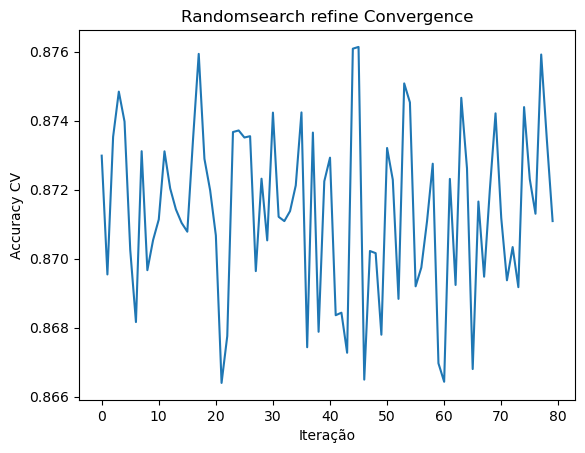

In [10]:
import matplotlib.pyplot as plt

results = search_2.cv_results_

plt.figure()
plt.plot(results['mean_test_score'])
plt.xlabel("Iteração")
plt.ylabel("Accuracy CV")
plt.title("Randomsearch refine Convergence")
plt.show()


Melhor modelo: RandomSearchCV refine com accuracy média de 0.8761


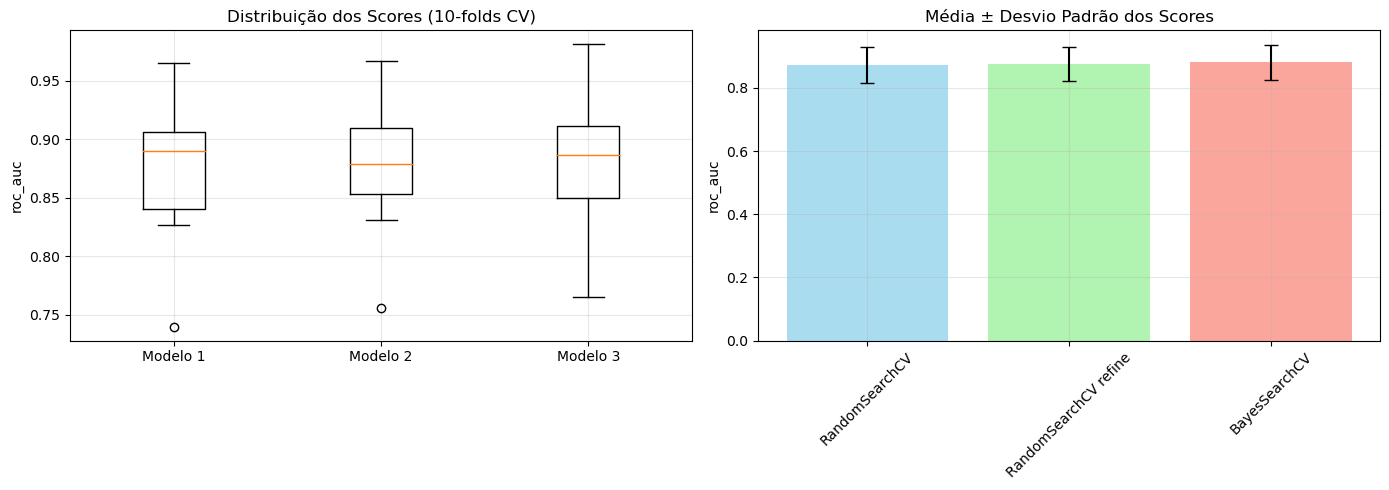

In [11]:
#Visualização opcional (se quiser plotar)
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Análise adicional: melhor modelo
means = [s1.mean(), s2.mean(), s3.mean()]
models = ["RandomSearchCV", "RandomSearchCV refine", "BayesSearchCV"]
best_idx = df_results['Test ROC-AUC'].astype(float).idxmax()
print(f"Melhor modelo: {models[best_idx]} com accuracy média de {means[best_idx]:.4f}")
print(f"{'='*70}")
#Boxplot comparativo
data = [s1, s2, s3]
ax1.boxplot(data, labels=['Modelo 1', 'Modelo 2', 'Modelo 3'])
ax1.set_title('Distribuição dos Scores (10-folds CV)')
ax1.set_ylabel('roc_auc')
ax1.grid(True, alpha=0.3)

# Barras com médias
x_pos = np.arange(len(models))
ax2.bar(x_pos, means, yerr=[s1.std(), s2.std(), s3.std()], 
        capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'salmon'])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models, rotation=45)
ax2.set_title('Média ± Desvio Padrão dos Scores')
ax2.set_ylabel('roc_auc')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()